# clustered ROM using rompy

rompy embedding -> clustering -> sub-domain roms

In [428]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import pandas as pd
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.mixture
import sklearn.metrics
import lalutils
import lalsimulation as lalsim
import phenom
import corner

<Figure size 640x480 with 0 Axes>

In [429]:
# so we can specify minimum cluster size
from k_means_constrained import KMeansConstrained

In [430]:
import rompy as rp

In [431]:
def resample(x, y, new_x):
    return IUS(x,y)(new_x)

In [432]:
def generate_data(q, chi1, chi2, m_total=100, deltaT=1 / 4096, f_min=10, approximant=lalsim.SEOBNRv4, t_min=-500, t_max=100, dt_M=0.75):
    """
    generate a single waveform
    """
    m1, m2 = phenom.m1_m2_M_q(m_total, q)
    eta = phenom.eta_from_q(q)
    p=lalutils.gen_td_wf_params(
        m1=m1,
        m2=m2,
        S1z=chi1,
        S2z=chi2,
        deltaT=deltaT,
        f_min=f_min,
        inclination=np.pi/3,
        approximant=approximant,
    )

    t, amp, phi = lalutils.gen_td_wf(p, t_min=None, t_max=None)

    # scale amp by eta
    amp = amp / eta

    assert t[0] <= t_min, 'probably need a lower f_min'
    assert t[-1] >= t_max, 'use lower t_max'

    new_t = np.arange(t_min, t_max, dt_M)
    amp = resample(t, amp, new_t)
    phi = resample(t, phi, new_t)

    return new_t, amp, phi

In [433]:
def generate_data_loop(qs, chi1s, chi2s, **kwargs):
    """
    loop over and generate many waveforms
    """
    ts=[]
    amps=[]
    phis=[]
    for i in range(len(qs)):
        q=qs[i]
        chi1=chi1s[i]
        chi2=chi2s[i]
        t_, amp_, phi_ = generate_data(q, chi1, chi2, **kwargs)
        
        ts.append(t_)
        amps.append(amp_)
        phis.append(phi_)

    times = ts[0]
    amps = np.array(amps)
    phis = np.array(phis)

    # hack to return what I want
    amps = np.real(amps * np.exp(-1.j*phis))
    # amps = phis - phis[:,0][:,None]
    
    return times, amps, phis

In [434]:
def seed_random_samples(n_samples):
    qs = np.random.uniform(1, 20, n_samples)
    chi1s = np.random.uniform(-1, 1, n_samples)
    chi2s = np.random.uniform(-1, 1, n_samples)

    return pd.DataFrame({'q':qs, 'chi1':chi1s, 'chi2':chi2s})

In [435]:
l0_data = {}
l0_data['parameters'] = seed_random_samples(10000)

In [436]:
features = list(l0_data['parameters'].columns)
features

['q', 'chi1', 'chi2']

In [437]:
l0_data['parameters'].head()

q      chi1      chi2
0  12.417864 -0.998784  0.033558
1  17.106699 -0.339189  0.019191
2   7.397382  0.523757 -0.093522
3  12.491140 -0.969258  0.904486
4  17.903455 -0.326561  0.805174

In [438]:
%%time
times, amps, phis = generate_data_loop(l0_data['parameters']['q'], l0_data['parameters']['chi1'], l0_data['parameters']['chi2'], approximant=lalsim.IMRPhenomT)

In [439]:
X = amps.copy()
del amps
del phis

In [440]:
times.shape

(800,)

In [441]:
l0_data['parameters'].shape

(10000, 3)

In [442]:
X.shape

(10000, 800)

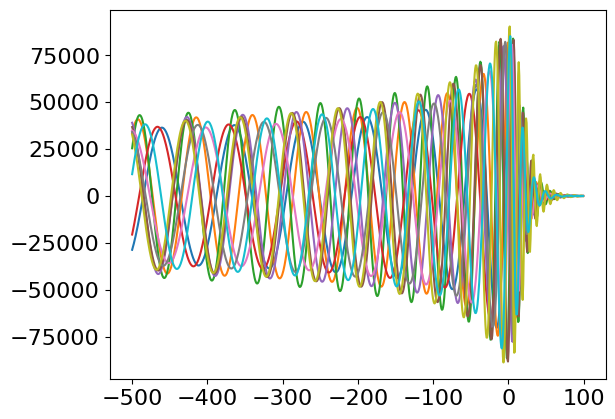

In [443]:
plt.plot(times, X[:10].T);

In [444]:
l0_data['scaler'] = sklearn.preprocessing.StandardScaler()
X_prime = l0_data['scaler'].fit_transform(X)

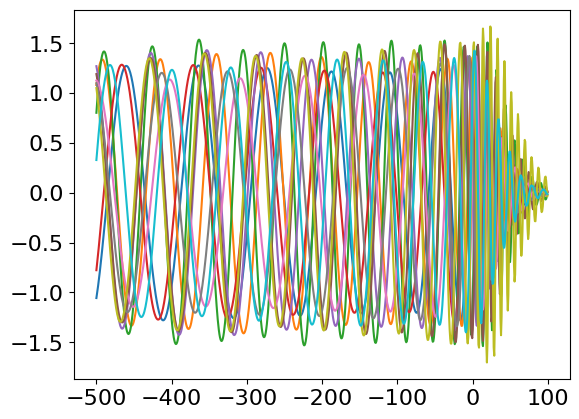

In [445]:
plt.plot(times, X_prime[:10].T);

In [446]:
l0_data['X'] = X.copy()
del X

l0_data['X_prime'] = X_prime.copy()
del X_prime

In [447]:
l0_data.keys()

dict_keys(['parameters', 'scaler', 'X', 'X_prime'])

In [448]:
def build_rb(times, X_train, tol, verbose=False):
    integration = rp.Integration([times[0], times[-1]], num=len(times), rule='trapezoidal')
    x = integration.nodes
    rb = rp.ReducedBasis(integration)
    rb.make(X_train, np.random.randint(0, len(X_train)), 1e-3, verbose=verbose, rel=True)


    # to match my convention of coeffs.shape = (n_samples, n_dim)
    rb.alpha = rb.alpha.T

    # compute a scaled version of the coefficients so that
    # it should be nicer when we using a clustering method
    alpha_scaler = sklearn.preprocessing.StandardScaler()
    alpha_prime = alpha_scaler.fit_transform(rb.alpha)

    return integration, rb, alpha_scaler, alpha_prime

In [449]:
l0_data['integration'], l0_data['rb'], l0_data['alpha_scaler'], l0_data['alpha_prime'] = build_rb(times, l0_data['X_prime'], 1e-3)

In [450]:
l0_data['rb'].size

46

In [ ]:
plt.plot(l0_data['rb'].basis[:2])

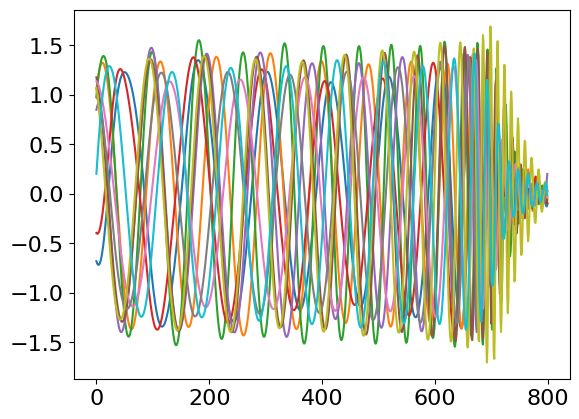

In [451]:
plt.plot(np.dot(l0_data['rb'].alpha[:10], l0_data['rb'].basis).T);

In [452]:
l0_data['rb'].alpha.shape

(10000, 46)

In [453]:
l0_data['rb'].basis.shape

(46, 800)

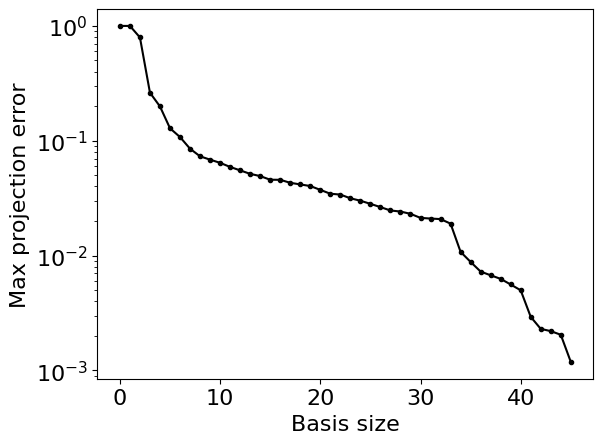

In [454]:
plt.semilogy(l0_data['rb'].errors/l0_data['rb'].errors[0], 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

In [455]:
def plot_rb_coeffs_corner(X, labels, max_dims=4):
    # restrict size of corner
    if X.shape[1] > max_dims:
        max_dims = max_dims
    else:
        max_dims = X.shape[1]
    corner.corner(X[:,:max_dims], labels=labels[:max_dims], plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1});

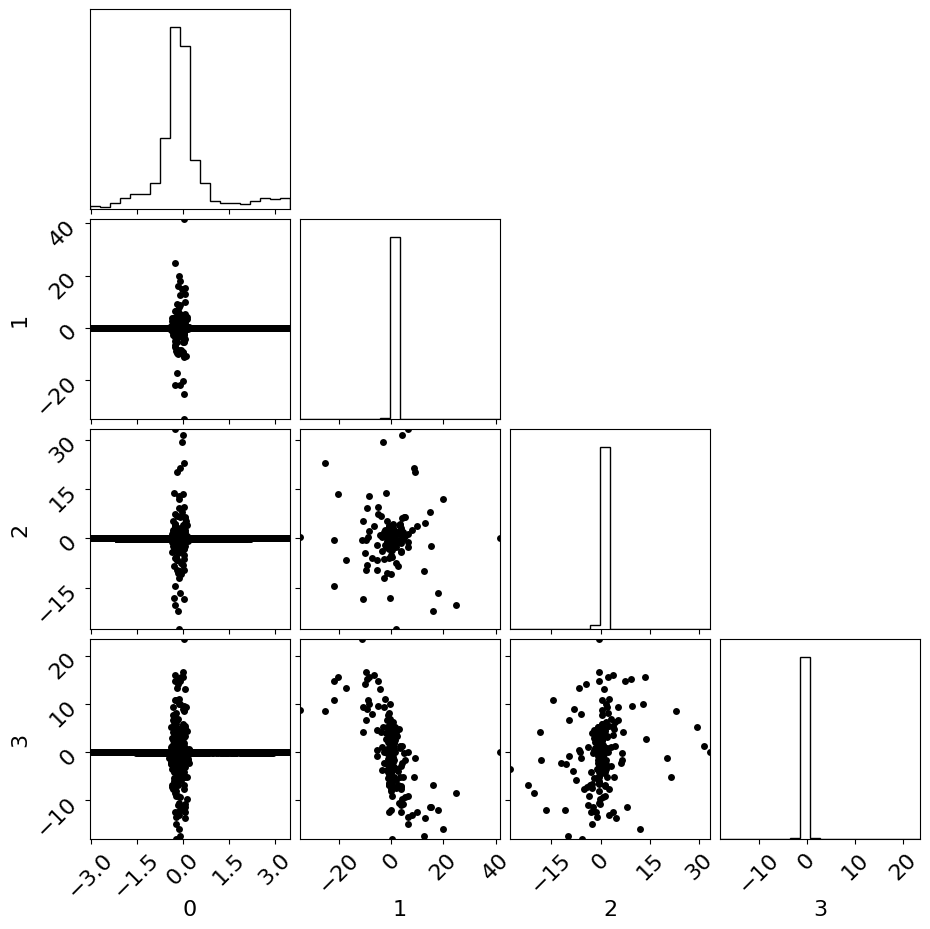

In [456]:
# plot_rb_coeffs_corner(l0_data['rb'].alpha, [i for i in range(l0_data['rb'].size)], max_dims=4)
plot_rb_coeffs_corner(l0_data['alpha_prime'], [i for i in range(l0_data['rb'].size)], max_dims=4)

In [457]:
def compute_clusters(parameters, X, method, method_kwargs):
    """
    parameters: data frame of physical parameters so we can assign cluster label


    KMeansConstrained: method_kwargs=dict(n_clusters=n_clusters,size_min=size_min)
    """
    assert method in ['gmm', 'kmeans', 'KMeansConstrained'], 'unknown method'
    parameters = parameters.copy()

    if method == 'gmm':
        gmm = sklearn.mixture.GaussianMixture(**method_kwargs).fit(X)
        labels = gmm.predict(X)
        unique_labels = np.unique(labels)
        parameters['cluster'] = labels
        
        return gmm, labels, unique_labels, parameters

    elif method == 'kmeans':
        kmeans = sklearn.cluster.KMeans(**method_kwargs).fit(X)
        labels = kmeans.labels_
        unique_labels = np.unique(labels)
        parameters['cluster'] = labels
        
        return kmeans, labels, unique_labels, parameters

    elif method =='KMeansConstrained':
        kmeans = KMeansConstrained(**method_kwargs).fit(X)
        labels = kmeans.labels_
        unique_labels = np.unique(labels)
        parameters['cluster'] = labels
        
        return kmeans, labels, unique_labels, parameters

In [458]:
l0_data['parameters'].shape

(10000, 3)

In [459]:
# n_clusters=5
# size_min=200
# l0_data['kmeans'], l0_data['labels'], l0_data['unique_labels'], l0_data['parameters_w_cluster'] = compute_clusters(l0_data['parameters'], l0_data['rb'].alpha, 'KMeansConstrained', {'n_clusters':n_clusters,'size_min':size_min})

n_clusters=100
size_min=100
l0_data['kmeans'], l0_data['labels'], l0_data['unique_labels'], l0_data['parameters_w_cluster'] = compute_clusters(l0_data['parameters'], l0_data['alpha_prime'], 'KMeansConstrained', {'n_clusters':n_clusters,'size_min':size_min})

In [460]:
l0_data['parameters_w_cluster']['cluster'].value_counts()

cluster
29    100
5     100
36    100
97    100
64    100
     ... 
0     100
93    100
76    100
71    100
98    100
Name: count, Length: 100, dtype: int64

In [461]:
l0_data['parameters_w_cluster']

q      chi1      chi2  cluster
0     12.417864 -0.998784  0.033558       29
1     17.106699 -0.339189  0.019191       61
2      7.397382  0.523757 -0.093522       94
3     12.491140 -0.969258  0.904486       31
4     17.903455 -0.326561  0.805174       41
...         ...       ...       ...      ...
9995  11.370284  0.060493 -0.069310       73
9996   4.841462  0.688495  0.928867       49
9997   2.461310 -0.191073 -0.699471       80
9998  19.526191  0.825395 -0.646422       30
9999  12.166121 -0.629887 -0.335800       85

[10000 rows x 4 columns]

In [462]:
def plot_rb_coeffs_corner_by_cluster(X, clusters, labels, max_dims=4):
    # restrict size of corner
    if X.shape[1] > max_dims:
        max_dims = max_dims
    else:
        max_dims = X.shape[1]

    for i, cluster in enumerate(np.unique(clusters)):
        idxs = np.arange(len(X))[clusters==cluster]
        to_plot = X[idxs][:,:max_dims]
        if i==0:
            fig = corner.corner(to_plot, color=f'C{i}', labels=labels[:max_dims], plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1})
        else:
            corner.corner(to_plot, color=f'C{i}', labels=labels[:max_dims], plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1}, fig=fig)

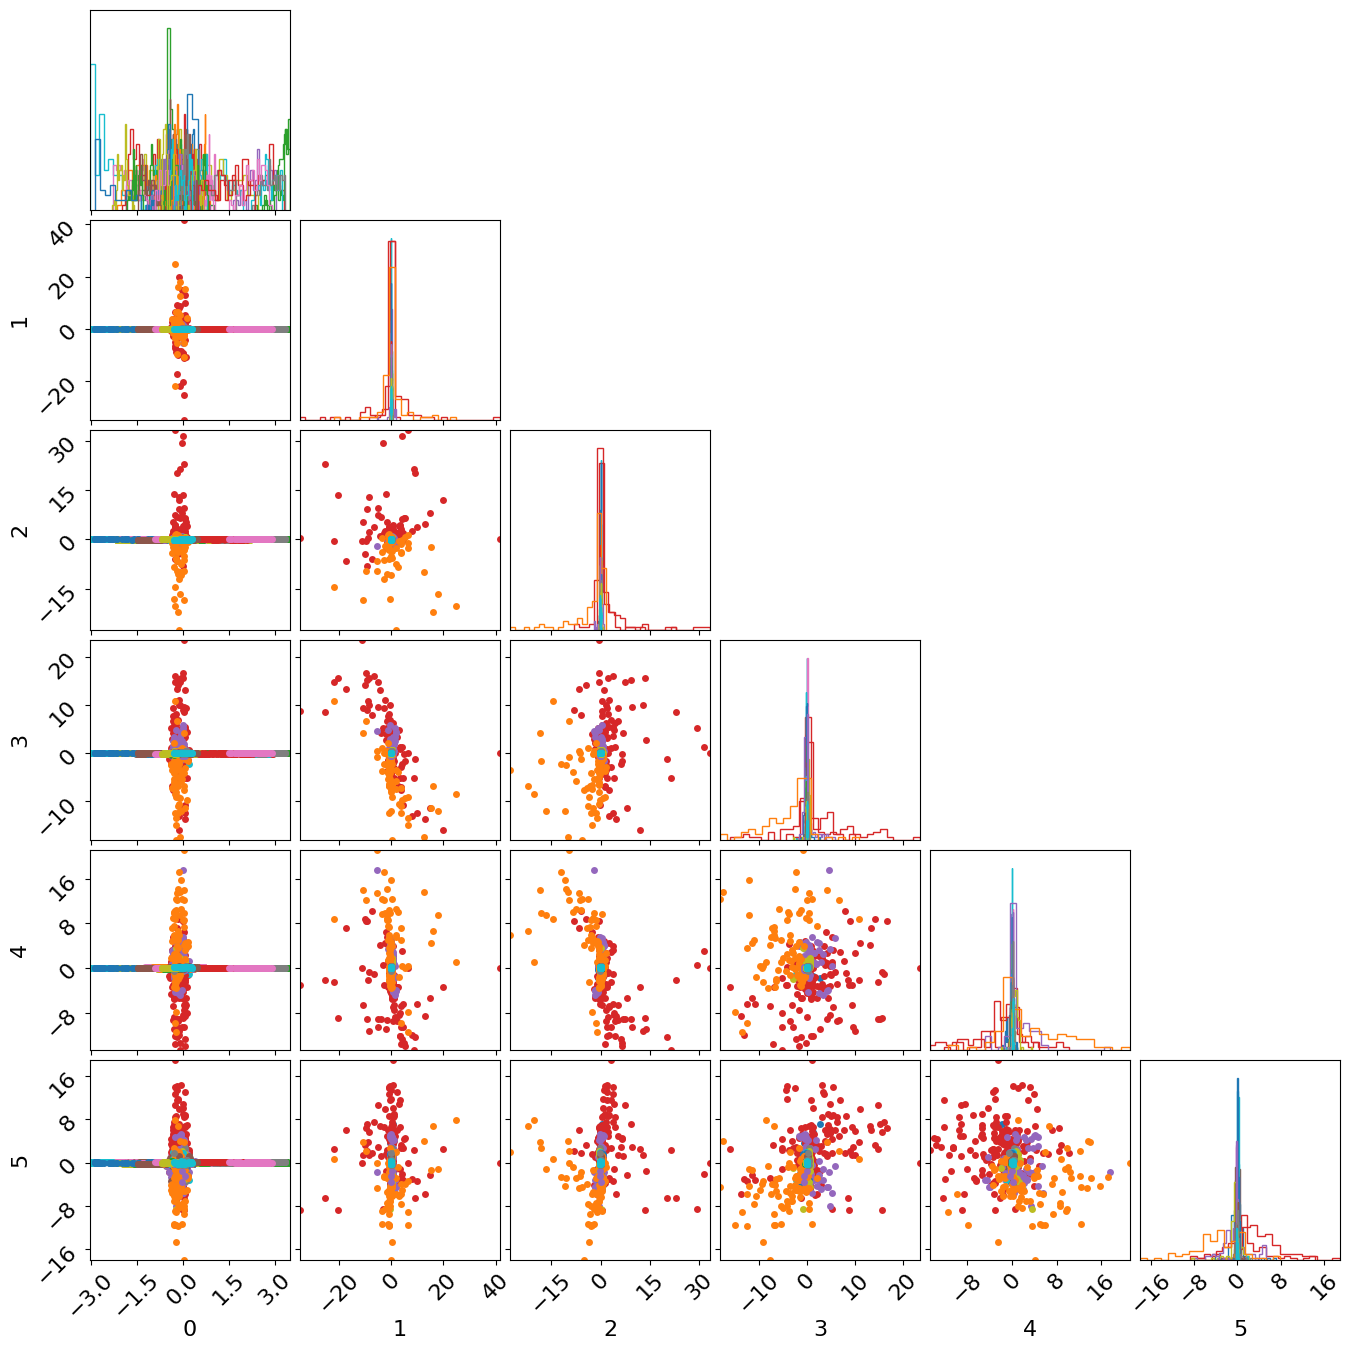

In [463]:
# plot_rb_coeffs_corner_by_cluster(l0_data['rb'].alpha, l0_data['parameters_w_cluster']['cluster'].values, [i for i in range(l0_data['rb'].size)], max_dims=6)
plot_rb_coeffs_corner_by_cluster(l0_data['alpha_prime'], l0_data['parameters_w_cluster']['cluster'].values, [i for i in range(l0_data['rb'].size)], max_dims=6)

In [464]:
def plot_parameters_corner_by_cluster(X, labels):
    clusters = X['cluster'].unique()
    for i, cluster in enumerate(clusters):
        to_plot = X[X['cluster'] == cluster][labels]
        if i==0:
            fig = corner.corner(to_plot, color=f'C{i}', labels=labels, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1})
        else:
            corner.corner(to_plot, color=f'C{i}', labels=labels, plot_contours=False, plot_density=False, data_kwargs={'ms':5, 'alpha':1}, fig=fig)

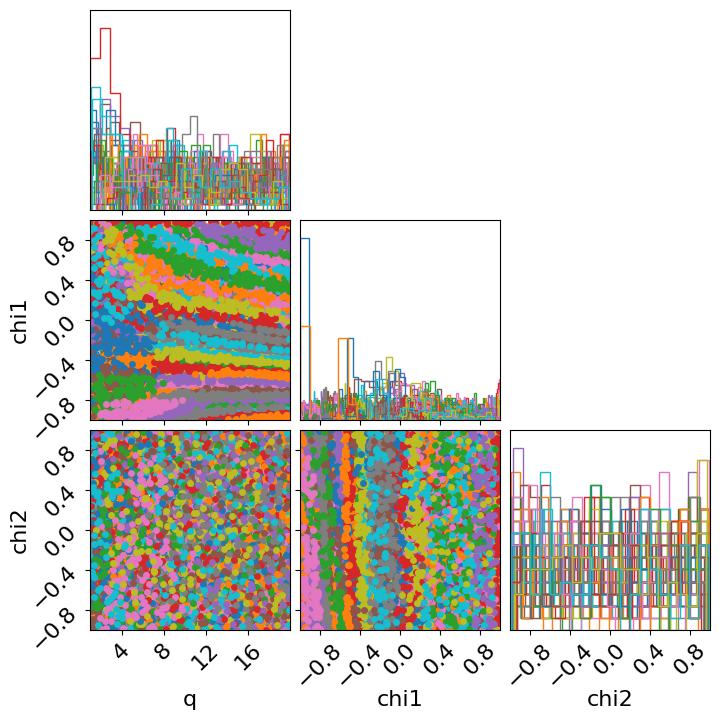

In [465]:
plot_parameters_corner_by_cluster(l0_data['parameters_w_cluster'], features)

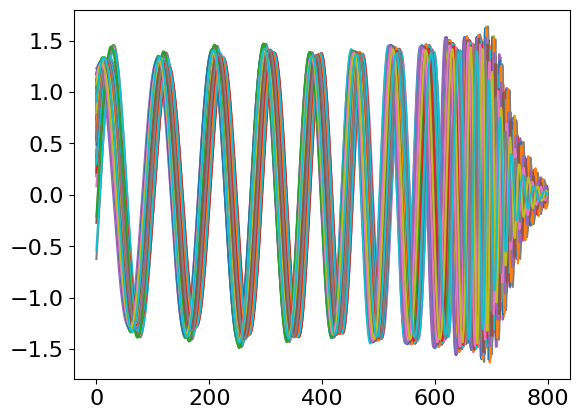

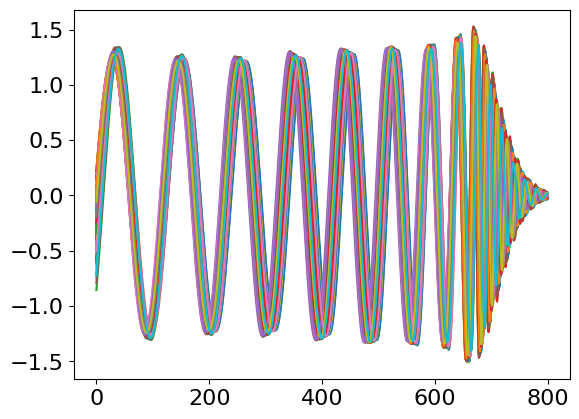

>>> Warning(Index already selected): Exiting greedy algorithm.


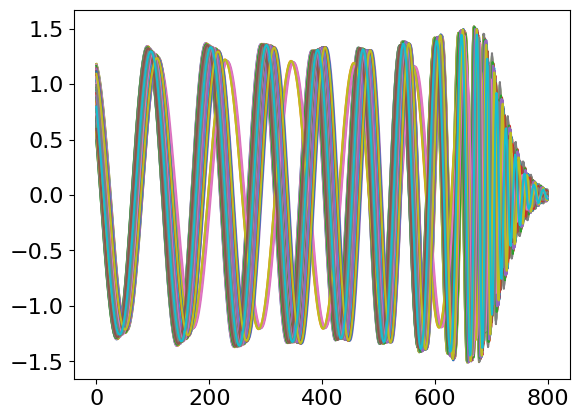

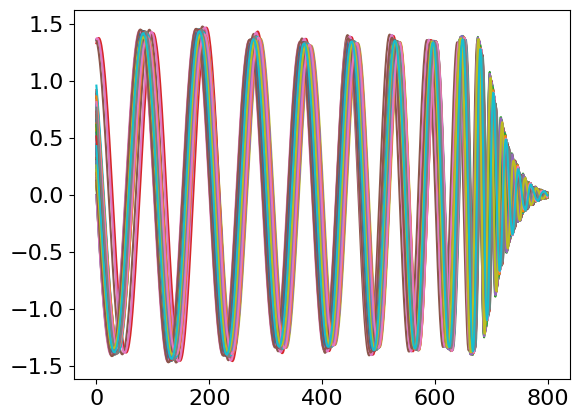

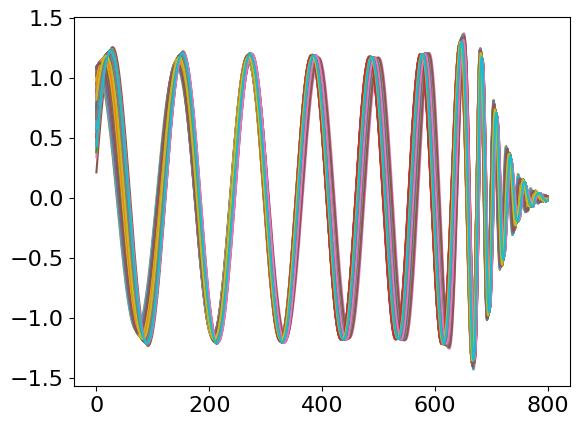

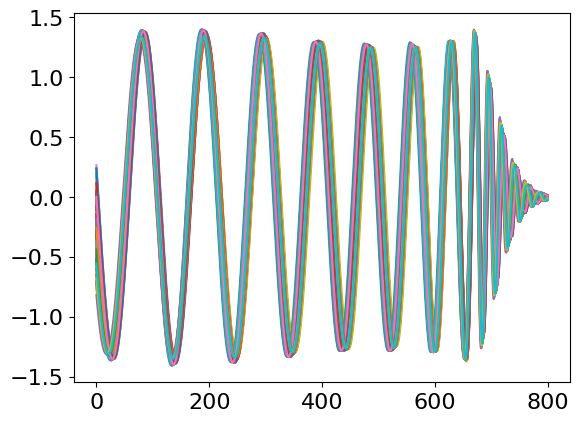

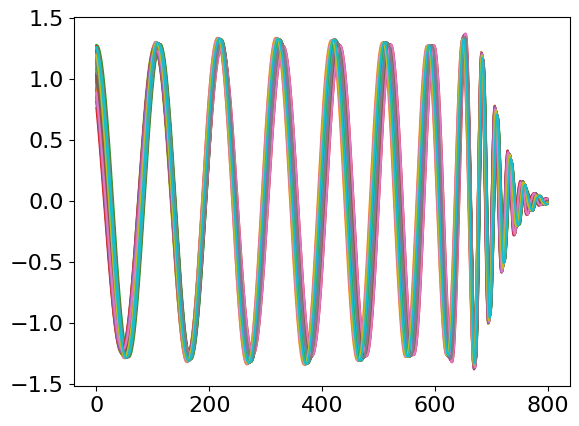

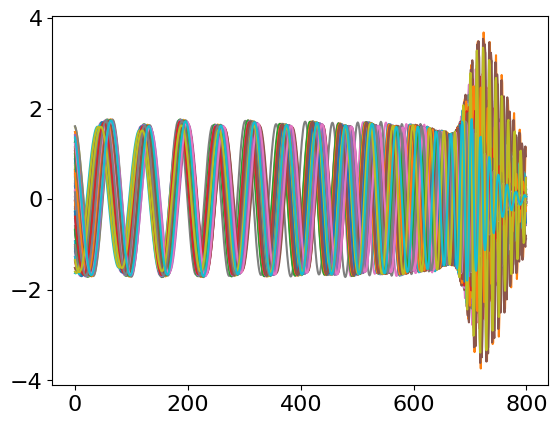

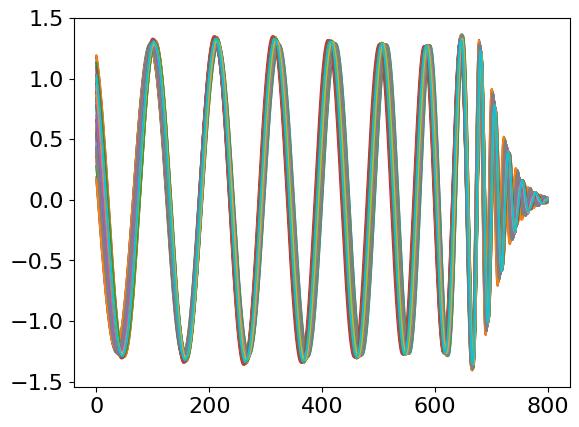

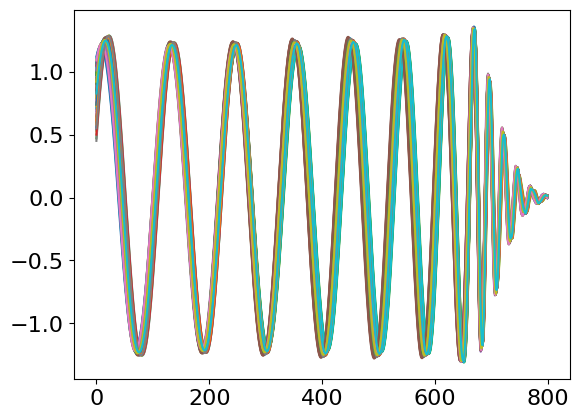

>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.
>>> Warning(Index already selected): Exiting greedy algorithm.


In [470]:
# loop over clusters, without generating new waveforms (fixme),
# and compute size of sub-basis
clusters_=[]
rb_sizes_=[]
for i, cluster in enumerate(range(n_clusters)):
    idxs=l0_data['parameters_w_cluster'][l0_data['parameters_w_cluster']['cluster']==cluster].index
    if i < 10:
        plt.figure()
        plt.plot(l0_data['X_prime'][idxs].T);
        plt.show()
        plt.close()
    integration, rb, _, _ = build_rb(times, l0_data['X_prime'][idxs], 1e-3, verbose=False)
    # print(cluster, rb.size)
    clusters_.append(cluster)
    rb_sizes_.append(rb.size)

In [477]:
# size of single basis covering whole of training space
l0_data['rb'].size

46

Text(0.5, 1.0, 'size of basis for each cluster')

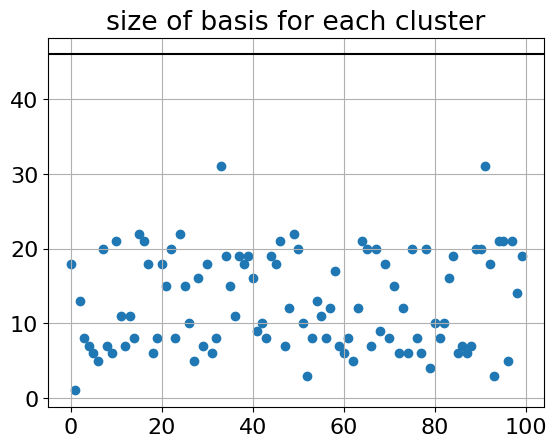

In [478]:
plt.scatter(clusters_, rb_sizes_)
plt.grid()

plt.axhline(l0_data['rb'].size, c='k')
plt.title("size of basis for each cluster")

In [483]:
np.median(l0_data['rb'].size/np.array(rb_sizes_))

4.007575757575758

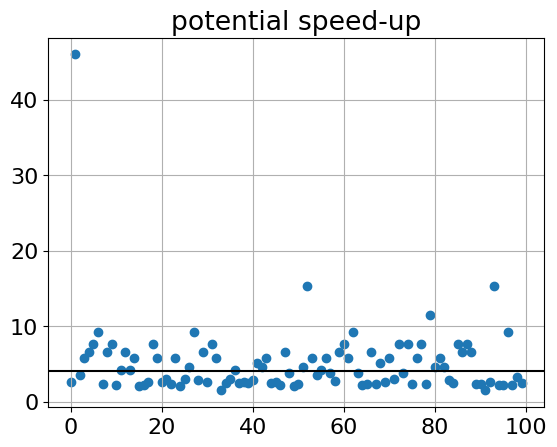

In [486]:
plt.scatter(clusters_, l0_data['rb'].size/np.array(rb_sizes_))
plt.grid()
plt.title("potential speed-up")
plt.axhline(np.median(l0_data['rb'].size/np.array(rb_sizes_)), c='k')